## Additional Modeling using Neural Network.  

It is a common approach for small amount of data, such as this homework, the data scientis would use traditional modeling techniques, such as SVM, ensemble learning algorithm or tree based algorithm. And leave neural network out of discussion. 

As short of learning samples, would make neural network harder to generalise and tuning parameters. 

But there are cerain good properties in Neural Network, such as auto feature engineering, ability to scope to larger dataset, would still make it a valid candidate to build a baseline model. 

In this code, I would use keras as the deep learning framework. 

In [29]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

from keras import Sequential 
from keras.layers import Dense,Input,Dropout,BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.regularizers import L1,L2,L1L2


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm
tqdm.pandas()


In [30]:
## Common methods to load and preprocess data
def load_data(filepath):
    
    columns = ['index','age','breed','last_vet_visit','hair_length','height','num_vet_visit','weight']
    
    return pd.read_csv(filepath,names=columns,header=0)

def remove_negative_value(df, columns):
    # df: dataframe of the data 
    # columns: list of columns need to remove negative value from 
    
    if len(columns) == 0 and df.empty:
        return df
    
    for col in columns:
        df = df[df[col]>=0]
    
    return df


def remove_extreme_outliers(df,columns):
    #for values great then quantile 99.9% then it would be treated as exterm outlier 
    # df: dataframe of the data 
    # columns: list of columns need to remove negative value from 
    
    if len(columns) == 0 and df.empty:
        return df
    
    for col in columns:
        limit = df[col].quantile(0.999)
        df = df[df[col]<limit] 
        
    return df

# Create a data pipeline to handle Category and scale numerical data

category_cols = ['breed']
numerical_cols = ['hair_length','height','num_vet_visit','weight']

pipeline = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(),numerical_cols),
        ('cat',OneHotEncoder(handle_unknown='ignore'),category_cols),
        
    ],remainder='passthrough')
)

def preprocess():
    
    filepath='data.csv'

    df = load_data(filepath)

    #remove  column 
    df = df.drop(columns=['index','last_vet_visit'])

    #remove any negative value
    df = remove_negative_value(df,['age','hair_length','height','num_vet_visit','weight'])

    #remove any exterme outliers
    df = remove_extreme_outliers(df,['age','hair_length','height','num_vet_visit','weight'])
 
    #split training, test and validation set 
    test_size = 0.2
    
    df_train,df_test = train_test_split(df, test_size=test_size,random_state=1)

    #using the pipeline to scale numerical column and onehot encoder for category column
    df_train = pipeline.fit_transform(df_train)
    df_test = pipeline.transform(df_test)

    
    
    return df_train,df_test

In [31]:
train,test=preprocess()
print('train size {}, test size {}'.format(train.shape,test.shape))

train size (232, 11), test size (58, 11)


In [32]:
def split_x_y(dataset):
    return dataset[:,:-1],dataset[:,-1]

In [33]:
x_train,y_train = split_x_y(train)
x_test,y_test = split_x_y(test)

In [34]:
# evaluate overall model performance

def evaluation(model,benchmark_score,history):
    score = model.evaluate(x_test, y_test, verbose=0)
    training_score = history.history['loss'][-1]
    
    print('Training Score:{}'.format(training_score))
    print('Test Score:{}'.format(score))
    if score < benchmark_score:
        print('The current score:{} BEATS the bechmark score {}'.format(score,benchmark_score))
        benchmark_score = score
    else:
        print('The current score:{} is NO BETTER the bechmark score {}'.format(score,benchmark_score))
        
    return benchmark_score
        
benchmark_score = 999

In [35]:
def model_def(input_shape):
    inputs = Input(shape=(input_shape,),name='input')
    
    hidden1 = Dense(20,name='hidden1',kernel_regularizer=L1L2(),)(inputs)
#     batch1 = BatchNormalization(name="BatchNorm1")(hidden1)
#     act1 = Activation('relu',name='Act1')(batch1)
    
    
    hidden2 = Dense(30,name='hidden2',kernel_regularizer=L1L2(),)(hidden1)
#     batch2 = BatchNormalization(name='BatchNorm2')(hidden2)
#     act2 = Activation('relu',name='Act2')(batch2)  
    
    drop1 = Dropout(0.3)(hidden2)
    
    hidden3 = Dense(20,name='hidden3',kernel_regularizer=L1L2(),)(drop1)
#     batch3 = BatchNormalization(name='BatchNorm3')(hidden3)
#     act3 = Activation('relu',name='Act3')(batch3)    
    
    hidden4 = Dense(30,name='hidden4',kernel_regularizer=L1L2(),)(hidden3)
#     batch4 = BatchNormalization(name='BatchNorm4')(hidden4)
#     act4 = Activation('relu',name='Act4')(batch4)

    drop2 = Dropout(0.3)(hidden4)
    
    hidden5 = Dense(5,name='hidden5',kernel_regularizer=L1L2(),)(drop2)
#     batch5 = BatchNormalization(name='BatchNorm5')(hidden5)
#     act5 = Activation('relu',name='Act5')(batch5)
    
#     drop2 = Dropout(0.2)(hidden5)、、、、、、、、、、、、、
    
    outputs = Dense(1,activation='linear',name='output')(hidden5)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [36]:
model= model_def(x_train.shape[1])
model.compile(optimizer ='adam',
              loss='mae')

#add Early stop to control training 
earlyStopping = EarlyStopping(monitor='val_loss',
                             patience=5,
                             mode='auto',
                             )

model.summary()

history = model.fit(x_train,y_train,
          batch_size=20, 
          epochs=1000,
          verbose=0,
         shuffle=True,
          validation_split=0.15,
         callbacks=[earlyStopping]
                   )

benchmark_score = evaluation(model,benchmark_score,history)

Model: "model_212"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
hidden1 (Dense)              (None, 20)                220       
_________________________________________________________________
hidden2 (Dense)              (None, 30)                630       
_________________________________________________________________
dropout_424 (Dropout)        (None, 30)                0         
_________________________________________________________________
hidden3 (Dense)              (None, 20)                620       
_________________________________________________________________
hidden4 (Dense)              (None, 30)                630       
_________________________________________________________________
dropout_425 (Dropout)        (None, 30)                0 

In [37]:
history.history['loss'][-1]

2.954664707183838

In [38]:
def plot_training_history_1(history):
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.gca().set_ylim(0,150)
    plt.gca().set_xlim(0,len(history.history['loss']))
    plt.show()

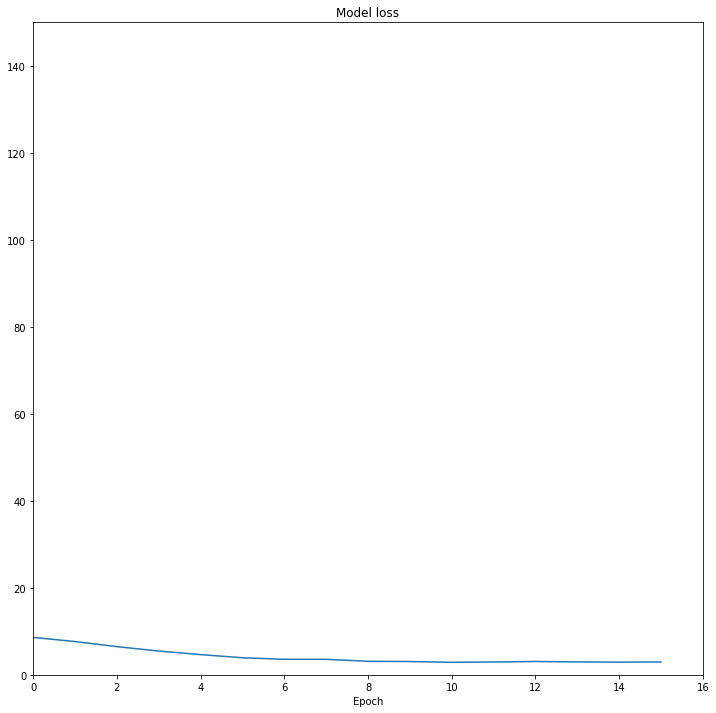

In [39]:
plot_training_history_1(history)

In [41]:
#once confirm the model parameter, training the final model without valididation split, to get the highest accuracy 

#add Early stop to control training 
earlyStopping_final = EarlyStopping(monitor='loss',
                             patience=5,
                             mode='auto',
                             )

model_performance = 999
final_model = None

for i in range(100):
    
    
    model= model_def(x_train.shape[1])
    model.compile(optimizer ='adam',
                  loss='mae')    

    history = model.fit(x_train,y_train,
              batch_size=20, 
              epochs=1000,
              verbose=0,
             shuffle=True,
             callbacks=[earlyStopping_final]
                       )

    score = evaluation(model,model_performance,history)
    
    if score < model_performance:
        model.save('cat_age_prediction_keras.h5')
        model_performance = score
        
        
print('Final Model Testing Score:{}'.format(model_performance))
        

Training Score:2.7560043334960938
Test Score:2.55083966255188
The current score:2.55083966255188 BEATS the bechmark score 999
Training Score:2.956094264984131
Test Score:2.4815452098846436
The current score:2.4815452098846436 BEATS the bechmark score 2.55083966255188
Training Score:2.9911856651306152
Test Score:2.4514853954315186
The current score:2.4514853954315186 BEATS the bechmark score 2.4815452098846436
Training Score:3.002077341079712
Test Score:2.6085314750671387
The current score:2.6085314750671387 is NO BETTER the bechmark score 2.4514853954315186
Training Score:2.826073169708252
Test Score:2.4691720008850098
The current score:2.4691720008850098 is NO BETTER the bechmark score 2.4514853954315186
Training Score:2.672393321990967
Test Score:2.4132816791534424
The current score:2.4132816791534424 BEATS the bechmark score 2.4514853954315186
Training Score:2.859128952026367
Test Score:2.4289138317108154
The current score:2.4289138317108154 is NO BETTER the bechmark score 2.4132816

In [42]:
# save data pipeline

from joblib import dump, load
dump(pipeline,'keras_model_data_trans_pipeline.joblib')

['keras_model_data_trans_pipeline.joblib']

In [43]:
# save test data set for validate saved model
dump(test,'testdata.joblib')

['testdata.joblib']